In [1]:
import pandas as pd
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from metrics import metrics
from matplotlib import pyplot as plt

In [2]:
RS = 42

## Random Forest

Выяснили:
1. Отношение сплита тренировочных данных особо на результат не влияет, то есть неравномерности в выборке нет.
2. Удаление коррелирующих параметров сильно на результат не влияет, только на скорость обучения. Разве что если удалить много параметров, показатели сильно ухудшаются.
3. Андерсэмплинг датасета чуть лучше чем балансировка весов, но с балансировкой есть возможность увеличить recall.

### 1. Разбиение данных

Accuracy:   0.9389089789951527
Precision:  0.8698727015558698
Recall:     0.46697038724373574
F1:         0.607707509881423


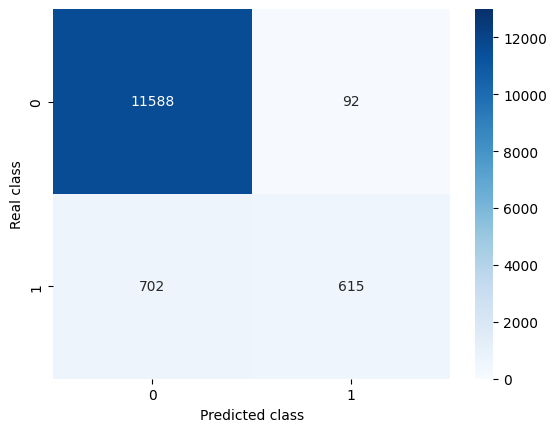

Accuracy:   0.9412187115305704
Precision:  0.8652946679139383
Recall:     0.48002075765438507
F1:         0.6174899866488651


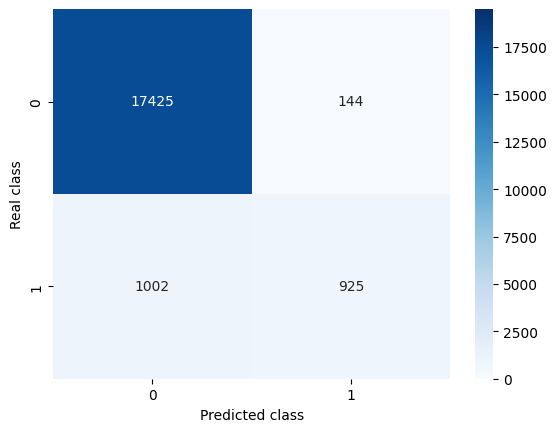

KeyboardInterrupt: 

In [3]:
data = pd.read_csv("../data/whole_data.csv").iloc[:, 4:].drop("type", axis=1).dropna()

features, labels = data.drop("present", axis=1), data["present"]

splits = [train_test_split(features, labels, random_state=RS, train_size=0.8),
          train_test_split(features, labels, random_state=RS, train_size=0.7),
          train_test_split(features, labels, random_state=RS, train_size=0.8, stratify=labels),
          train_test_split(features, labels, random_state=RS, train_size=0.7, stratify=labels)]

for sp in splits:
  clf = RandomForestClassifier(n_jobs=-1)
  clf.fit(sp[0], sp[2])
  metrics(clf.predict(sp[1]), sp[3])

**Recall** показывает насколько много в определенных как переменные переменных.

**Precision** показывает насколько много переменных звезд мы не упустили.

### 2. Коррелирующие параметры

<Axes: >

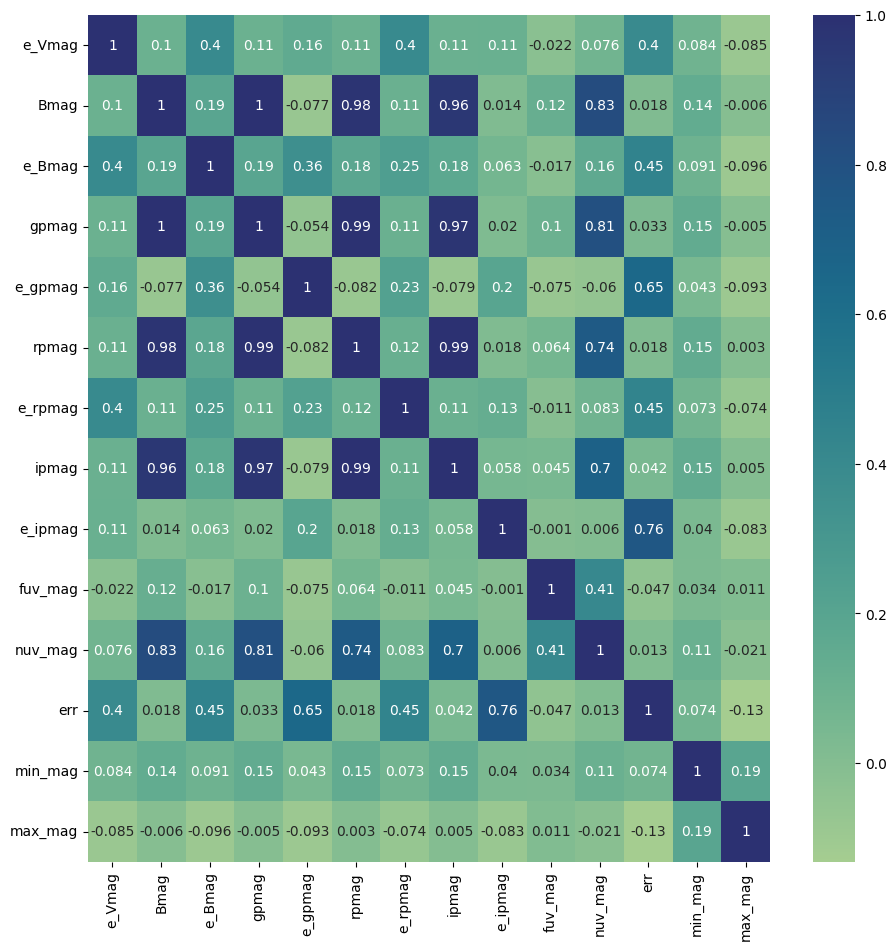

In [26]:
plt.figure(figsize=(11, 11))

corr = features.corr()
sns.heatmap(corr.round(3), cmap="crest", annot=True)

In [27]:
candidates = []  # видно, что связаны одни и те же, поэтому одномерного списка достаточно
treshold = 0.8
for row in corr.iterrows():
  for col in row[1].items():
    if row[0] != col[0] and col[1] > treshold and col[0] not in candidates:
      candidates.append(col[0])

candidates

['gpmag', 'rpmag', 'ipmag', 'nuv_mag', 'Bmag']

Accuracy:   0.9407555589751481
Precision:  0.8825174825174825
Recall:     0.4791192103264996
F1:         0.6210629921259843


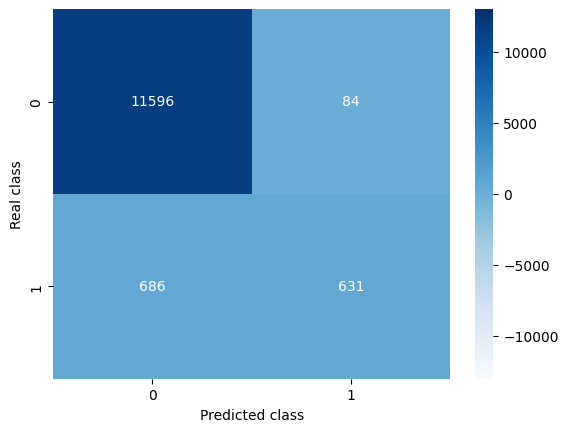

Accuracy:   0.9358313456951605
Precision:  0.8901453957996769
Recall:     0.4183750949126803
F1:         0.5692148760330579


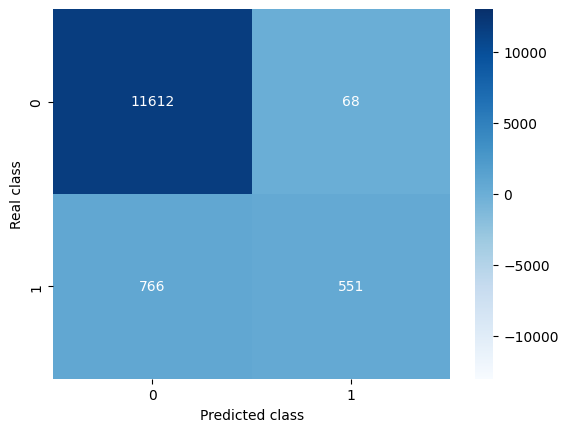

Accuracy:   0.9276756174501808
Precision:  0.8792756539235412
Recall:     0.33181473044798787
F1:         0.48180815876515987


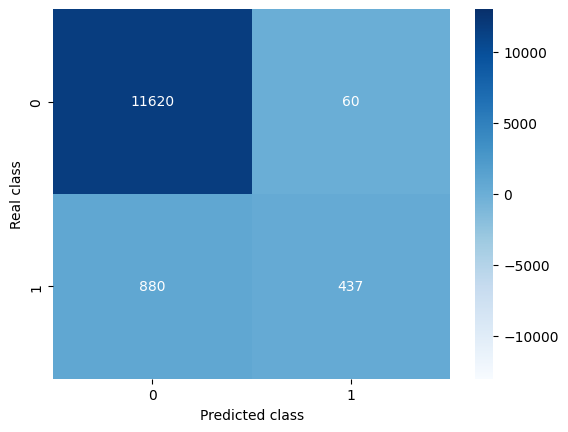

Accuracy:   0.9197507117027006
Precision:  0.8494897959183674
Recall:     0.2528473804100228
F1:         0.38970157987126974


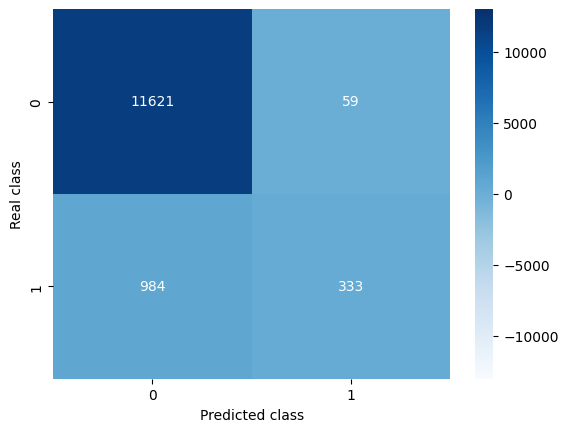

In [28]:
features_copy = features.copy()
# хотя бы один из связанных должен остаться
draw_data = []
for c in candidates[:-1]:
  features_copy.drop(c, inplace=True, axis=1)
  sp = train_test_split(features_copy, labels, random_state=RS, train_size=0.8)
  clf = RandomForestClassifier(n_jobs=-1)
  clf.fit(sp[0], sp[2])
  draw_data.append(metrics(clf.predict(sp[1]), sp[3]))
  draw_data[-1]["Deleted"] = c

# sns.relplot(draw_data)
# можно понять, что nuv_magnitude is important

<Axes: xlabel='Deleted'>

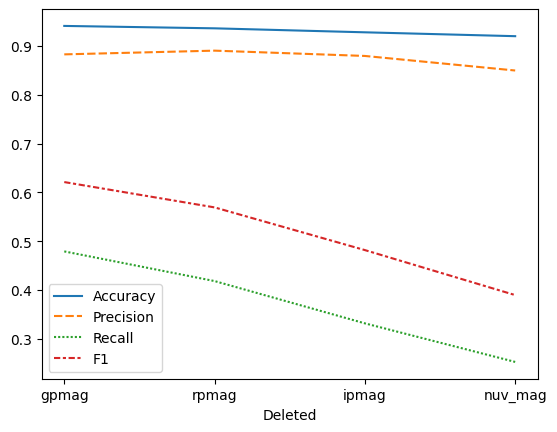

In [29]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index(["Deleted"])
sns.lineplot(draw_df)

### 3. Undersmapling vs balanced

In [30]:
X, x, Y, y = train_test_split(features, labels, random_state=RS, train_size=0.8)

classes = Y.unique()
weights = [compute_class_weight('balanced', classes=classes, y=Y)]
weights

[array([0.55636772, 4.93516233])]

With weight [0.55636772 4.93516233]
Accuracy:   0.9372932215126568
Precision:  0.8921875
Recall:     0.43356112376613515
F1:         0.5835462442514052


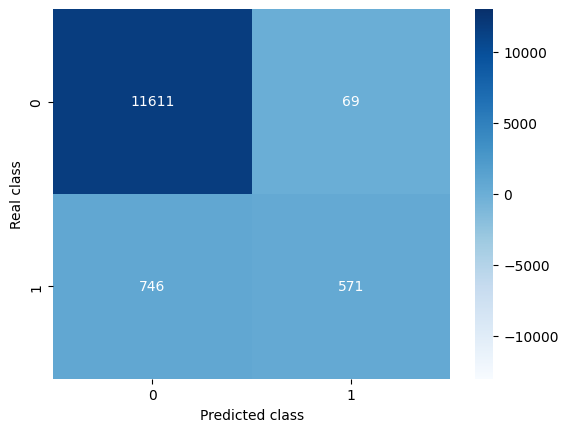

With weight [1, 20]
Accuracy:   0.9379087481726552
Precision:  0.897196261682243
Recall:     0.43735763097949887
F1:         0.5880551301684533


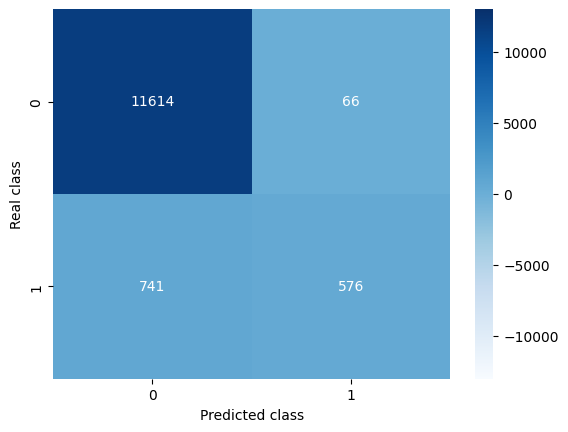

With weight [1, 30]
Accuracy:   0.9372932215126568
Precision:  0.8849693251533742
Recall:     0.4381169324221716
F1:         0.5860843067546978


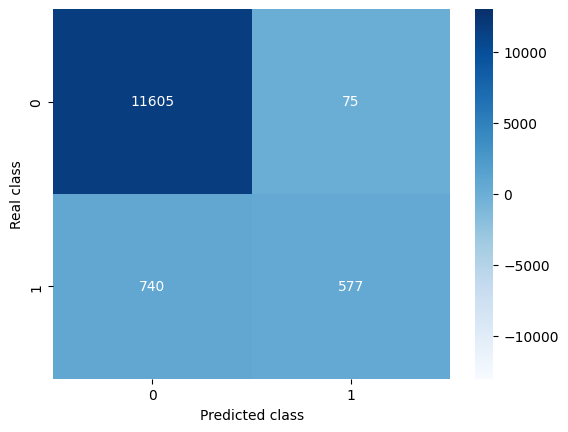

With weight [1, 60]
Accuracy:   0.935600523197661
Precision:  0.8896103896103896
Recall:     0.4160971905846621
F1:         0.5669943093636834


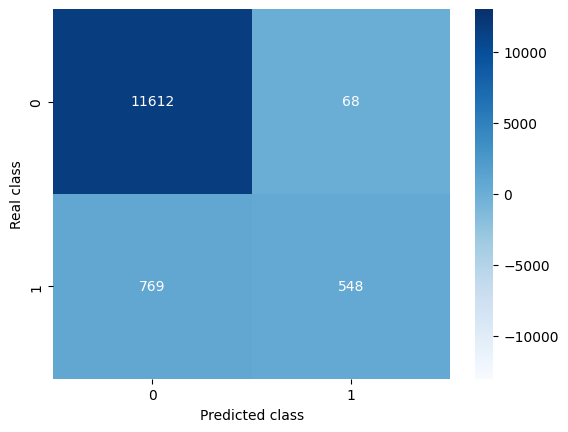

In [31]:
weights += [[1, 20], [1, 30], [1, 60]]

# в декоратор бы это все)
draw_data = []
for w in weights:
  clf = RandomForestClassifier(class_weight=dict(zip(classes, w)), n_jobs=-1)
  clf.fit(X, Y)
  print(f"With weight {w}")
  draw_data.append(metrics(clf.predict(x), y))
  draw_data[-1]["Weights"] = round(w[1] / w[0], 2)

Видно, что веса особо эффекта не приносят

<Axes: xlabel='Weights'>

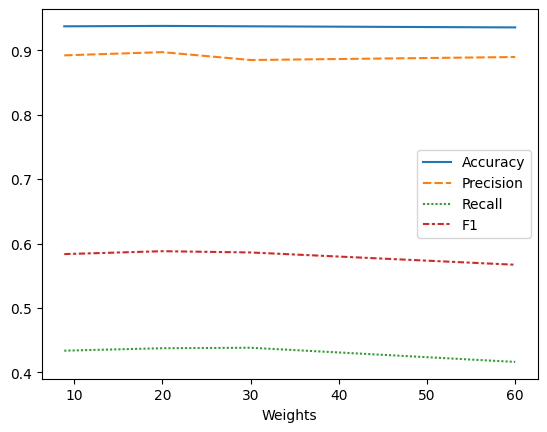

In [32]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index(["Weights"])
sns.lineplot(draw_df)

Try different split ratios for undersampling training

Undersmapling with ratio 1/1
Accuracy:   0.8756636146803108
Precision:  0.4470046082949309
Recall:     0.9574791192103265
F1:         0.6094731754470759


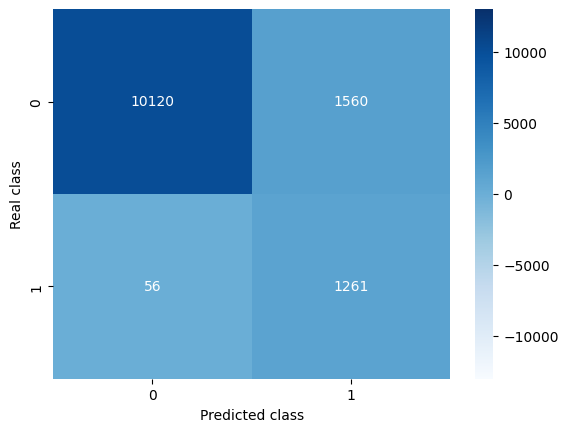

Undersmapling with ratio 1/2
Accuracy:   0.9263676232976841
Precision:  0.5910010111223458
Recall:     0.8876233864844343
F1:         0.7095599393019727


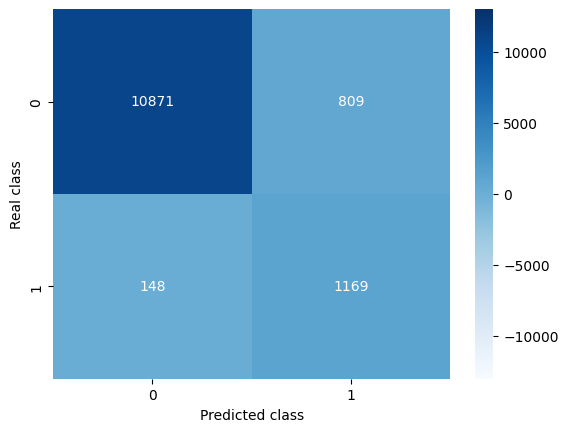

Undersmapling with ratio 1/3
Accuracy:   0.9389859198276526
Precision:  0.6748998664886515
Recall:     0.7676537585421412
F1:         0.7182948490230906


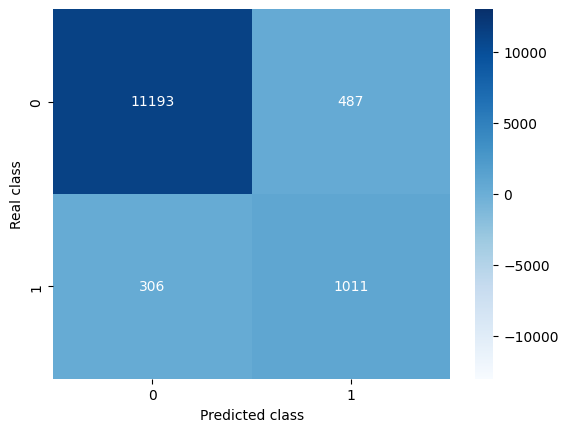

Undersmapling with ratio 1/4
Accuracy:   0.9437562514426406
Precision:  0.7370550161812298
Recall:     0.6917236142748672
F1:         0.7136701919310615


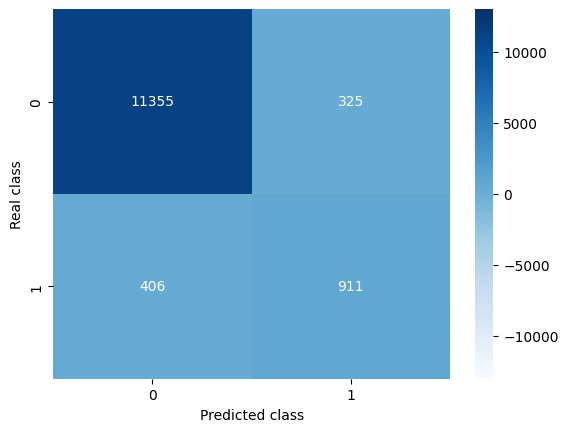

In [33]:
N = Y[Y == 1].size  # number of variable stars
new_train = pd.concat([X, Y], axis=1)

draw_data = []
for r in [1, 2, 3, 4]:
  _temp = pd.concat([new_train[new_train.present == 0].sample(N * r),
                     new_train[new_train.present == 1].sample(N)])
  X, Y = _temp.drop("present", axis=1), _temp["present"]
  clf = RandomForestClassifier(n_jobs=-1)
  clf.fit(X, Y)
  print(f"Undersmapling with ratio 1/{r}")
  draw_data.append(metrics(clf.predict(x), y))
  draw_data[-1]["Ratio"] = r

<Axes: xlabel='Ratio'>

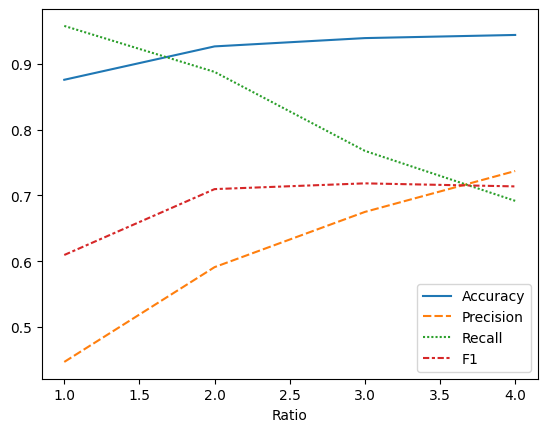

In [34]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index(["Ratio"])
sns.lineplot(draw_df)

### Hyperparameter tuning

Будем тренировать не с балансировкой, а с меньшим датасетом, так как он показывает результаты получше. Ну может это и странно, что я опираюсь на результаты для теста, надо потом проверить с другим рандомным состоянием.

Балансировку выберем не 1/1, опять же по тесту, видимо есть золотая середина между размером выборки и ее сбалансированностью.

In [35]:
_temp = pd.concat([new_train[new_train.present == 0].sample(N * 3),
                     new_train[new_train.present == 1].sample(N)])
X, Y = _temp.drop("present", axis=1), _temp["present"]

In [ ]:
params = {
  "n_estimators": [100, 300, 500],
  "max_depth": [8, 16, 32],  # FIXME: maybe too deep??
  # "min_samples_leaf" minimum samples from dataset for a node
  # "min_samples_split": [],  let's say we don't need simple trees, but overfitting?
  "n_jobs": [-1]
}

clf = GridSearchCV(RandomForestClassifier(), params)
clf.fit(X, Y)

Этот результат более надежный, так как модели при тренировке проходили кросс-валидацию, значит мы, условно, не подбирали параметры по тестовой выборке.

Матрица стала намного лучше, теперь отношение True positive и False negative гораздо удобоваримее.

Accuracy:   0.9430637839501423
Precision:  0.6950642325895876
Recall:     0.7805618830675778
F1:         0.7353361945636624


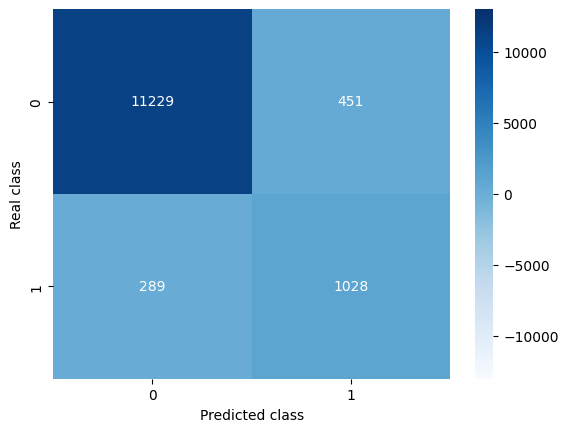

In [15]:
metrics(clf.best_estimator_.predict(x), y, to_return=False)

### Combine high recall and high precision

In [16]:
_temp = pd.concat([new_train[new_train.present == 0].sample(N * 3),
                   new_train[new_train.present == 1].sample(N)])
X, Y = _temp.drop("present", axis=1), _temp["present"]

In [17]:
params = {
    "n_estimators": [200],
    "class_weight": [{1: 10}, {1: 20}, {1: 40}],  # high penalty for false positive
    "max_depth": [8, 16],
}
rf_precision = GridSearchCV(RandomForestClassifier(
), params, scoring='precision', n_jobs=-1).fit(X, Y).best_estimator_
rf_precision

RandomForestClassifier(class_weight={1: 10}, max_depth=16, n_estimators=200)

Accuracy:   0.8632761406478419
Precision:  0.4200833912439194
Recall:     0.9179954441913439
F1:         0.5764004767580453


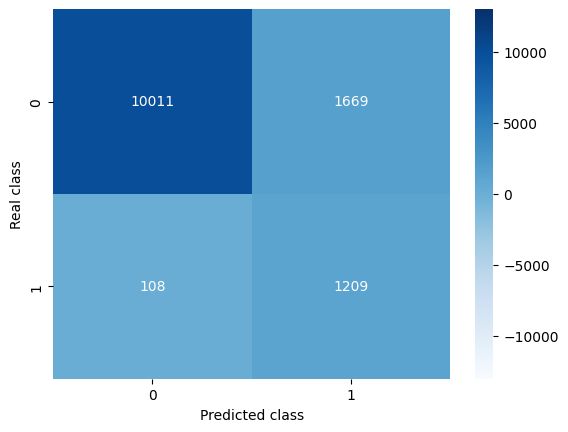

In [18]:
metrics(rf_precision.predict(x), y, to_return=False)

In [19]:
params = {
    "n_estimators": [200],
    "class_weight": [{0: 10}, {0: 20}, {0: 40}],  # high penalty for FN
    "max_depth": [8, 16]
}
rf_recall = GridSearchCV(RandomForestClassifier(
), params, scoring='recall', n_jobs=-1).fit(X, Y).best_estimator_
rf_recall

RandomForestClassifier(class_weight={0: 10}, max_depth=16, n_estimators=200)

Accuracy:   0.9262906824651843
Precision:  0.7524613220815752
Recall:     0.4062262718299165
F1:         0.5276134122287969


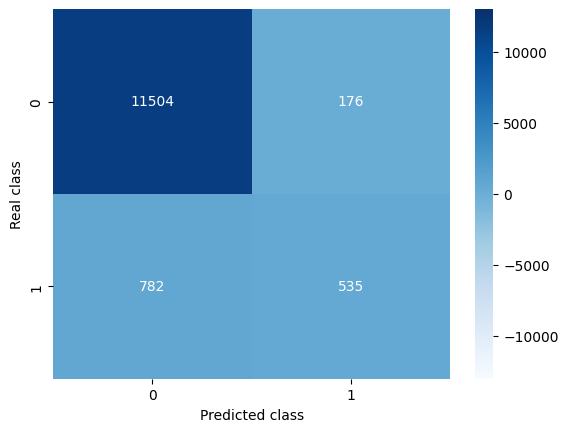

In [20]:
metrics(rf_recall.predict(x), y, to_return=False)

In [21]:
ensemble = VotingClassifier(
    estimators=[
        ('precision_model', RandomForestClassifier(class_weight={1: 10}, max_depth=16, n_estimators=200)),
        ('recall_model', RandomForestClassifier(class_weight={0: 10}, max_depth=16, n_estimators=200))
    ],
    voting='hard'  # just majority vote
)

ensemble.fit(X, Y)

VotingClassifier(estimators=[('precision_model',
                              RandomForestClassifier(class_weight={1: 10},
                                                     max_depth=16,
                                                     n_estimators=200)),
                             ('recall_model',
                              RandomForestClassifier(class_weight={0: 10},
                                                     max_depth=16,
                                                     n_estimators=200))])

Accuracy:   0.9282911441101793
Precision:  0.7947932618683001
Recall:     0.3940774487471526
F1:         0.5269035532994923


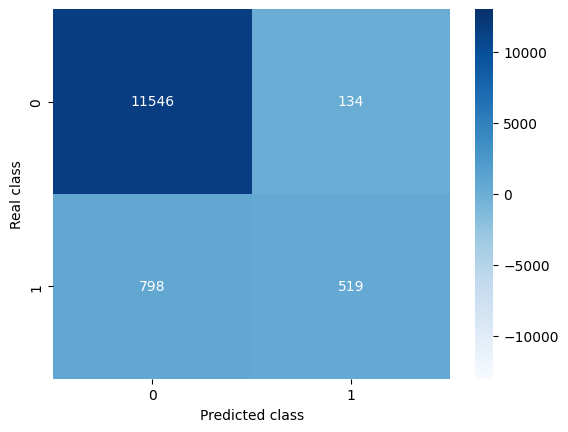

In [22]:
metrics(ensemble.predict(x), y, to_return=False)